In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader

import matplotlib.pylab as plt
import numpy as np
import os
from tqdm import tqdm

from torchsummary import summary

In [18]:
#download mnist
mnist_train = dset.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(),target_transform=None ,download=True)
mnist_test  = dset.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor(),target_transform=None ,download=True)

train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=2, drop_last = True)
test_loader   = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2, drop_last = True)
print("download 완료!")

#param
lr = 0.00001
EPOCHE =200

#model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            #conv
            nn.Conv2d(1,16,5), # 28 -> 24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 24 -> 20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 20 -> 10
            nn.Conv2d(32,64,5), # 10 -> 6
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 6 -> 3
        )

        self.fc = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cuda:1"
print(f"device : {device}")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

download 완료!
device : cuda:0


In [19]:
#train
loss_arr = []
best_acc = 0
for i in range(EPOCHE):
    loss_sum = 0
    print(f"EPOCH : {i}/{EPOCHE}")
    for [image,label] in tqdm(train_loader, desc = "train"):  #enumerate 사용시 인덱스와 튜플을 같이 넘겨줌
        optimizer.zero_grad()
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)

        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.cpu().detach().numpy()

    loss_arr.append(loss_sum)

    correct = 0
    total = 0
    for [image,label] in tqdm(test_loader, desc = "val"):  #enumerate 사용시 인덱스와 튜플을 같이 넘겨줌
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        output_max = torch.argmax(output,1)

        correct += (output_max == y).sum()
        total += y.shape[0]

    acc = correct/total*100
    print(f"accuracy : {acc:2f} %")

    torch.save({
        'epoch': i,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss.cpu().detach().numpy()
    },
    f"model/last.pt")

    if best_acc < acc:
        torch.save({
            'epoch': i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'loss' : loss.cpu().detach().numpy()
        },
        f"model/best.pt")
    


print("train 완료!\n")

val: 100%|██████████| 39/39 [00:00<00:00, 72.53it/s]


accuracy : 98.878204 %
EPOCH : 199/200


val: 100%|██████████| 39/39 [00:00<00:00, 67.90it/s]


accuracy : 98.838142 %
train 완료!



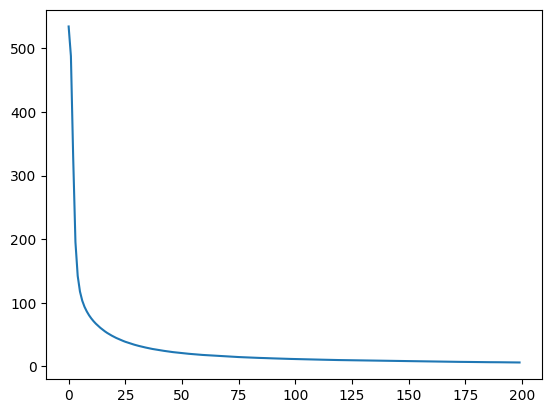

6.132190704345703


In [20]:
#print loss
plt.plot(loss_arr)
plt.show()
print(loss_arr[-1])

In [21]:
model.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[[[ 1.2841e-01,  1.0270e-01,  7.0391e-02,  2.4227e-01,  7.5258e-02],
                        [ 2.1360e-01,  1.7276e-01,  8.9741e-02, -3.7331e-02,  1.2775e-02],
                        [ 2.1603e-01, -6.3848e-02,  1.5832e-02, -5.8578e-03,  1.3425e-01],
                        [ 9.5091e-02,  1.9930e-01, -4.1957e-02,  8.3127e-02,  1.5608e-01],
                        [ 1.5508e-01,  1.5464e-01,  7.4032e-02, -9.8765e-02,  1.0526e-02]]],
              
              
                      [[[ 2.5987e-01,  2.7326e-01,  1.3555e-01,  8.4710e-02,  1.4162e-01],
                        [-9.1099e-02, -3.6597e-02,  1.4135e-01,  1.8192e-01,  2.2997e-01],
                        [ 9.9327e-05, -2.1998e-01, -1.3872e-01,  1.0984e-01, -1.3041e-02],
                        [-2.4703e-01, -9.7210e-02,  1.5588e-01,  2.2668e-01, -7.7242e-02],
                        [ 8.7748e-02,  5.7028e-02,  7.8097e-02,  3.8929e-02,  2.0716e-01]]],
              
         

In [22]:
#모델의 파라미터만 저장
torch.save(model.state_dict(), os.path.join("model/","only_param.pt"))

#아키텍쳐도 저장
torch.save(model, os.path.join("model/","with_architecture.pt"))

In [23]:
#파라미터만 저장했을때 의 블러오기
new_model_1 = CNN().to(device)
new_model_1.load_state_dict(torch.load(os.path.join("model/","only_param.pt")))


<All keys matched successfully>

In [24]:
#모델 자체를 불러오기
new_model_2 = torch.load(os.path.join("model/","with_architecture.pt"))

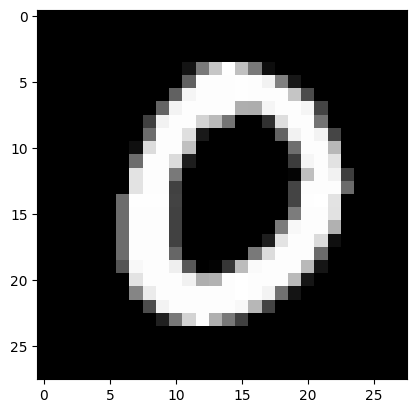

label : 0
infer : 0
True


In [25]:
#이미지 확인
random_num = np.random.randint(0, 10000)
image = mnist_test[random_num][0]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
#infer
with torch.no_grad():
    #output = model.forward(image.reshape([1,1,28,28]).to(device))
    output = new_model_1.forward(image.reshape([1,1,28,28]).to(device))
    #output = new_model_2.forward(image.reshape([1,1,28,28]).to(device))
    _,output_max = torch.max(output,1)

print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])